In [1]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

%matplotlib inline

In [2]:
data_path = 'D://Dataset/support-ticket-classification/'

In [3]:
ddata = pd.read_csv(data_path + 'all_tickets.csv')

In [4]:
ddata.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [5]:
ddata.isnull().sum()

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64

In [6]:
ddata.shape

(48549, 9)

In [7]:
ddata.columns

Index(['title', 'body', 'ticket_type', 'category', 'sub_category1',
       'sub_category2', 'business_service', 'urgency', 'impact'],
      dtype='object')

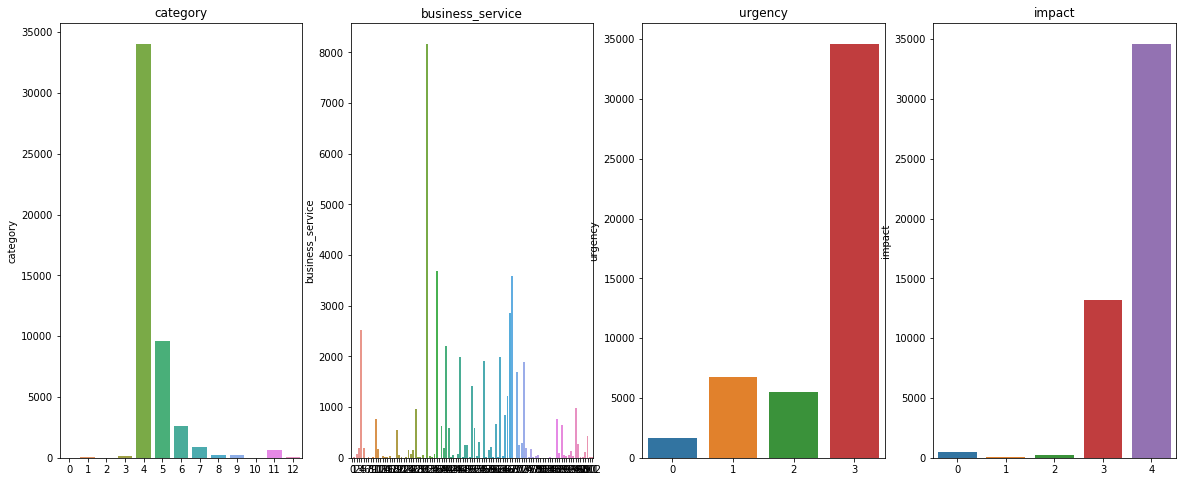

In [8]:
f, ax = plt.subplots(1, 4, figsize = (20, 8))
for i, col in enumerate(["category", 'business_service', 'urgency', 'impact']):
    sns.barplot(x = ddata[col].value_counts().index, y = ddata[col].value_counts(), ax = ax[i]).set_title(col)

In [9]:
ddata.category.value_counts()

4     34061
5      9634
6      2628
7       921
11      612
8       239
9       191
3       137
1        72
12       45
0         4
2         3
10        2
Name: category, dtype: int64

In [10]:
# we remove some category that not sufficient to make a model
drop_index = ddata[ddata['category'].isin([0,2,10])].index

In [11]:
ddata.drop(drop_index, axis = 0, inplace=True)

In [12]:
map_label = dict((k, i) for i, k in enumerate(ddata.category.unique()))

In [13]:
map_label

{4: 0, 6: 1, 5: 2, 7: 3, 11: 4, 1: 5, 8: 6, 12: 7, 3: 8, 9: 9}

In [14]:
ddata['category_remap'] = ddata.category.map(map_label)

In [15]:
ddata.shape

(48540, 10)

## Cleansing

In [16]:
stopword = stopwords.words('english')

In [17]:
stem = PorterStemmer()

In [18]:
lemma = WordNetLemmatizer()

In [19]:
def cleansing(sentence):
    word_list = word_tokenize(sentence)
    word_list = [word for word in word_list if word not in stopword]
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [stem.stem(word) for word in word_list]
    word_list = [lemma.lemmatize(word) for word in word_list]
    
    text = " ".join(word_list)
    
    return text

In [20]:
ddata['body_cleansing'] = ddata.body.apply(cleansing)

In [21]:
ddata.drop(ddata[ddata.body_cleansing.str.len() < 90].index, inplace=True)

ddata.shape

(30380, 11)

In [22]:
ddata.category_remap.value_counts().sort_index()

0    21097
1     1886
2     6118
3      409
4      387
5       39
6      215
7       40
8       44
9      145
Name: category_remap, dtype: int64

In [23]:
ddata.reset_index(drop=True, inplace=True)

## Feature Extraction

In [ ]:
def fe(content):
    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(content)
    
    return X

In [ ]:
X = fe(ddata.body_cleansing)

In [ ]:
def word_cloud(label):
    body_cleansing_list = list(ddata[ddata['category_remap'] == label].body_cleansing)
    text = " ".join(body_cleansing_list)
    text_tokenize = word_tokenize(text)
    word_freq = dict(Counter(text_tokenize))
    
    return word_freq

In [ ]:
for label in sorted(ddata.category_remap.unique()):
    word_freq, label = word_cloud(label), label

In [ ]:
word_freq['octob']

In [ ]:
d_w_f = pd.DataFrame(data = {'word': list(word_freq.keys()), 'freq': list(word_freq.values())})

In [ ]:
d_w_f.sort_values(by = 'freq', ascending = False)

In [ ]:
ddata[ddata['category_remap'] == label]

## Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, ddata.category_remap, test_size = 0.20)

In [ ]:
sk = StratifiedKFold(n_splits=5)

In [ ]:
score_stratified = []
for train, test in sk.split(X, ddata.category_remap):
    X_train, X_test, y_train, y_test = X[train], X[test], ddata.loc[train, 'category_remap'], ddata.loc[test, 'category_remap']
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    score_stratified.append(eval(y_test, y_pred))

In [ ]:
score_stratified

In [ ]:
pd.DataFrame(data = score_stratified)

## Multinomial Naive Bayes

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(X_train, y_train)

In [ ]:
y_pred = mnb.predict(X_test)

In [ ]:
eval(y_test, y_pred)

In [ ]:
y_test.value_counts()

In [ ]:
np.unique(y_pred, return_counts=True)

## Support Vector Machine

In [ ]:
clf_svc = SVC()

In [ ]:
clf_svc.fit(X_train, y_train)

In [ ]:
y_pred_svc = clf_svc.predict(X_test)

In [ ]:
eval(y_test, y_pred_svc)

## Random Forest

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
rfc.fit(X_train, y_train)

In [ ]:
RandomForestClassifier

## Evaluation

In [ ]:
def eval(y_true, y_pred):
    f1score = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average = 'macro')
    
    return {'f1-score': f1score,
            'recall': recall,
            'precision': precision
            }

## K Folds

In [ ]:
k = KFold(n_splits=5, random_state=123)

In [ ]:
for train, test in k.split(X, ddata.category):
    X_train, X_test, y_train, y_test = X[train], X[test], ddata.loc[train, 'category'], ddata.loc[test, 'category']
    
    mnb = MultinomialNB()
    mnb.
    break